In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

2022-02-17 09:13:01.039525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 09:13:01.039585: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
ds_preview, info = tfds.load("penguins/processed", split=["train[:20%]", "train[20%:]"], as_supervised=True, with_info=True)

2022-02-17 09:13:05.343958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-17 09:13:05.344004: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-17 09:13:05.344021: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (calixto-VirtualBox): /proc/driver/nvidia/version does not exist
2022-02-17 09:13:05.345722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
ds_test = ds_preview[0]
ds_train = ds_preview[1]
assert isinstance(ds_test, tf.data.Dataset)

In [4]:
info.features

FeaturesDict({
    'features': Tensor(shape=(4,), dtype=tf.float32),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
})

In [5]:
df_test = tfds.as_dataframe(ds_test.take(5), info)
df_test

2022-02-17 09:13:10.401513: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,features,species
0,"ndarray(shape=(4,), dtype=float32)",2
1,"ndarray(shape=(4,), dtype=float32)",2
2,"ndarray(shape=(4,), dtype=float32)",2
3,"ndarray(shape=(4,), dtype=float32)",2
4,"ndarray(shape=(4,), dtype=float32)",2


In [6]:
df_train = tfds.as_dataframe(ds_train.take(5), info)
df_train

2022-02-17 09:13:12.267308: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,features,species
0,"ndarray(shape=(4,), dtype=float32)",0
1,"ndarray(shape=(4,), dtype=float32)",2
2,"ndarray(shape=(4,), dtype=float32)",1
3,"ndarray(shape=(4,), dtype=float32)",0
4,"ndarray(shape=(4,), dtype=float32)",0


In [7]:
ds_train_batch = ds_train.batch(32)

In [8]:
features, labels = next(iter(ds_train_batch))

2022-02-17 09:13:18.047452: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


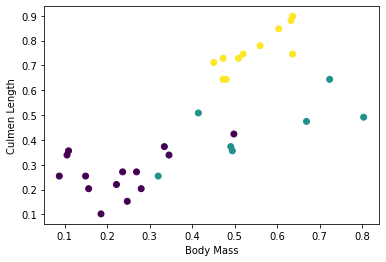

In [9]:
plt.scatter(features[:,0], features[:,2], c=labels, cmap="viridis")
plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

In [12]:
predictions = model(features)
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.33304197, 0.27525225, 0.39170578],
       [0.36391062, 0.26307032, 0.37301907],
       [0.33312508, 0.25406396, 0.41281092],
       [0.33350754, 0.2838932 , 0.38259926],
       [0.32979488, 0.27191246, 0.3982927 ]], dtype=float32)>

In [16]:
f"Prediction: {tf.argmax(predictions, axis=1)}, Labels: {labels}"

'Prediction: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2], \nLabels: [0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0]'

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [20]:
def loss(model, x, y, training):
    y_ = model(x, training=training)
    
    return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print(f"Loss test: {l}")

Loss test: 1.0830934047698975


In [21]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [27]:
loss_value, grads = grad(model, features, labels)

print(f"Step: {optimizer.iterations.numpy()}, Initial Loss: {loss_value.numpy()}")

Step: 1, Initial Loss: 1.081369161605835


In [29]:
optimizer.apply_gradients(zip(grads, model.trainable_variables))

print(f"Step: {optimizer.iterations.numpy()}, Loss: {loss(model, features, labels, training=True).numpy()}")

Step: 3, Loss: 1.07810640335083


In [30]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
    for x, y in ds_train_batch:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        epoch_loss_avg.update_state(loss_value)
        epoch_accuracy.update_state(y, model(x, training=True))
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if not epoch % 50:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, epoch_loss_avg.result(), epoch_accuracy.result()))

Epoch 000: Loss: 1.067, Accuracy: 35.581%
Epoch 050: Loss: 0.724, Accuracy: 79.026%
Epoch 100: Loss: 0.544, Accuracy: 80.524%
Epoch 150: Loss: 0.478, Accuracy: 80.524%
Epoch 200: Loss: 0.432, Accuracy: 80.524%


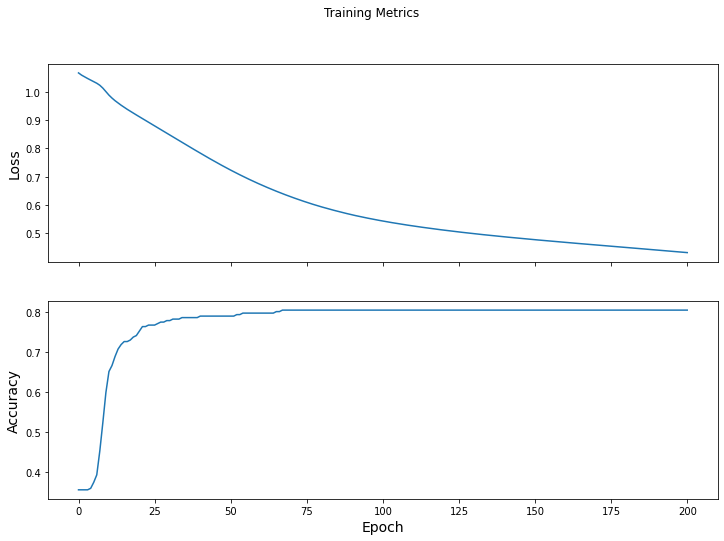

In [36]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle("Training Metrics")

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [39]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
    logits = model(x, training=False)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int64)
    test_accuracy(prediction, y)
    
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 76.119%


In [45]:
predict_ds = tf.convert_to_tensor([
    [.3, .8, .4, .5],
    [.4, .1, .8, .5],
    [.7, .9, .8, .4]
])

class_names = ["Adélie", "Chinstrap", "Gentoo"]

predictions = model(predict_ds, training=False)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Adélie (71.7%)
Example 1 prediction: Gentoo (98.6%)
Example 2 prediction: Adélie (66.0%)
